In [1]:
%load_ext autoreload
import sys
sys.path.append('../..')

In [2]:
import numpy as np

In [3]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
video_path = '/home/paulo/Vídeos/russomano.mp4'

In [5]:
dir_path = video_path.split('.')[0]
dir_path

'/home/paulo/Vídeos/russomano'

# Extract Video Frames

In [6]:
cap=cv2.VideoCapture(video_path)

In [7]:
fps = int(round(cap.get(cv2.CAP_PROP_FPS)))

In [8]:
fps

30

In [9]:
if os.path.isdir(dir_path):
    os.rmdir(dir_path)
os.mkdir(dir_path)

In [10]:
i=1
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    if i%fps == 0:
        cv2.imwrite(f'{dir_path}/frame_{i}.jpg',frame)
    i+=1

## Get urls

In [11]:
from faces_clustering import get_files_folder, FeatureExtractor

Using TensorFlow backend.


In [12]:
from tqdm import tqdm

In [13]:
extractor = FeatureExtractor('senet50')

In [14]:
frames_url = get_files_folder(dir_path)

In [15]:
faces_dict = {}
for url in tqdm(frames_url):
    faces_dict[url] = extractor.get_embeddings(url)


100%|██████████| 88/88 [00:55<00:00,  1.60it/s]


In [16]:
all_urls = []
all_faces = []
all_embs = []
all_bounds = []
for url in frames_url:
    embs, faces, bounds = faces_dict[url]
    for emb, face, bound in zip(embs, faces,bounds):
        all_urls.append(url)
        all_faces.append(face)
        all_embs.append(emb)
        all_bounds.append(bound)

In [17]:
dt_sw = pd.DataFrame(all_urls, columns=['urls'])

In [18]:
dt_sw['embeddings'] = all_embs
dt_sw['faces'] = all_faces
dt_sw['bounds'] = all_bounds

In [19]:
dt_sw[['urls','embeddings','bounds']].head()

,urls,embeddings,bounds
0,/home/paulo/Vídeos/russomano/frame_2550.jpg,-,-
1,/home/paulo/Vídeos/russomano/frame_2100.jpg,"[3.7179267, 4.6528873, 0.017838672, 0.15773018...","(404, 714, 148, 558)"
2,/home/paulo/Vídeos/russomano/frame_1350.jpg,"[3.22991, 2.1992908, 0.010703873, 0.016793361,...","(402, 736, 139, 589)"
3,/home/paulo/Vídeos/russomano/frame_1410.jpg,"[5.9985175, 2.2471037, 0.04628593, 0.4311825, ...","(419, 734, 141, 574)"
4,/home/paulo/Vídeos/russomano/frame_2490.jpg,"[7.267554, 0.10854488, 0.005832151, 0.00175472...","(457, 764, 107, 521)"


In [20]:
dt_sw.to_pickle(f'{video_path}.pkl')

# Clustering

In [21]:
from faces_clustering import silhuoette

In [22]:
dt_sw = pd.read_pickle(f'{video_path}.pkl')
dt_sw.shape

(90, 4)

In [23]:
valid = dt_sw.embeddings.apply(lambda x: str(x) != '-')
dt_sw = dt_sw.loc[valid]

In [24]:
dt_sw.shape

(82, 4)

In [25]:
embs = [list(emb) for emb in dt_sw.embeddings.values]


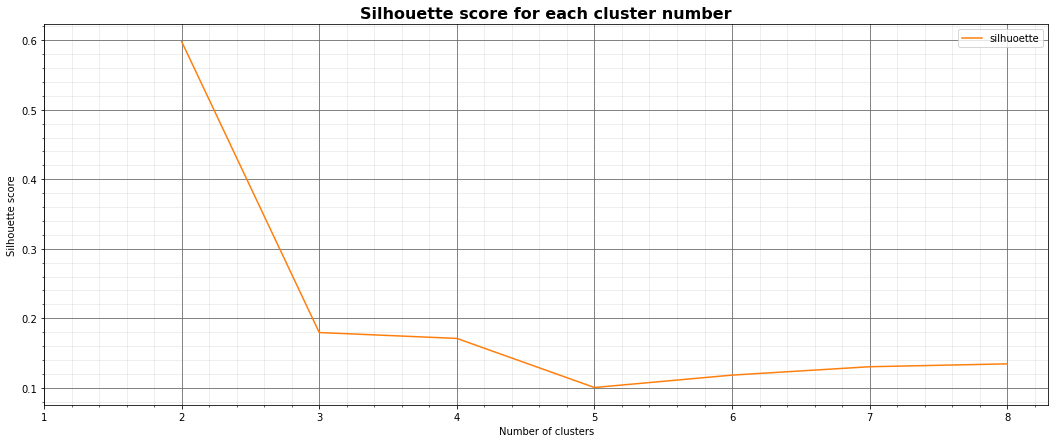

Best cluster number is 2


In [26]:
clusters_silhouette = silhuoette(embs,alg = "agglomerative")

In [27]:
dt_sw[['urls','embeddings']].head()

,urls,embeddings
1,/home/paulo/Vídeos/russomano/frame_2100.jpg,"[3.7179267, 4.6528873, 0.017838672, 0.15773018..."
2,/home/paulo/Vídeos/russomano/frame_1350.jpg,"[3.22991, 2.1992908, 0.010703873, 0.016793361,..."
3,/home/paulo/Vídeos/russomano/frame_1410.jpg,"[5.9985175, 2.2471037, 0.04628593, 0.4311825, ..."
4,/home/paulo/Vídeos/russomano/frame_2490.jpg,"[7.267554, 0.10854488, 0.005832151, 0.00175472..."
5,/home/paulo/Vídeos/russomano/frame_2040.jpg,"[3.5916798, 1.8003845, 0.017169695, 0.01869046..."


In [28]:
alg = 'agglomerative'

In [29]:
#clusterer = Clusterer(n_clusters = 2, face_embeddings = dt_sw,algs=[alg])

In [30]:
#clusters, _ = clusterer.clusterize()

In [31]:
#clusters.head()

clusters = dt_sw.copy()
clusters[f'cluster_{alg}'] = clusters_silhouette
clusters[['urls','embeddings',f"cluster_{alg}"]].head()

,urls,embeddings,cluster_agglomerative
1,/home/paulo/Vídeos/russomano/frame_2100.jpg,"[3.7179267, 4.6528873, 0.017838672, 0.15773018...",0
2,/home/paulo/Vídeos/russomano/frame_1350.jpg,"[3.22991, 2.1992908, 0.010703873, 0.016793361,...",0
3,/home/paulo/Vídeos/russomano/frame_1410.jpg,"[5.9985175, 2.2471037, 0.04628593, 0.4311825, ...",0
4,/home/paulo/Vídeos/russomano/frame_2490.jpg,"[7.267554, 0.10854488, 0.005832151, 0.00175472...",0
5,/home/paulo/Vídeos/russomano/frame_2040.jpg,"[3.5916798, 1.8003845, 0.017169695, 0.01869046...",0


In [32]:
faces_samples = clusters[[f'cluster_{alg}','faces']].sort_values(
    f'cluster_{alg}').groupby(f'cluster_{alg}').head(1).faces.values

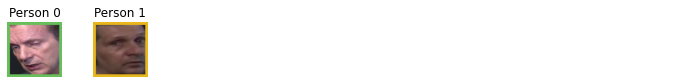

In [33]:
colors = list(np.random.random(size=(len(faces_samples),3)) * 256)
def show_people_video():
    fig, axes = plt.subplots(nrows=1, ncols=max(len(faces_samples),8), figsize=(12, 1))
    #fig.tight_layout()
    #fig.subplots_adjust(hspace=0, wspace=0)
    i = 0
    [axi.set_axis_off() for axi in axes.ravel()]
    for sample in faces_samples:
        #axes.figure(figsize=(2,3))
        image = cv2.rectangle(sample, (0,0), sample.shape[0:2], colors[i], int(sample.shape[0]/10))

        axes[i].set_title(f'Person {i}')
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_aspect('equal')
        i = i+1

show_people_video()


# Clusters by frame

In [34]:
clusters_urls = clusters[[f'cluster_{alg}','urls','bounds']]

In [35]:
frames = clusters_urls.urls.apply(lambda x: int(x.split('.')[0].split('/')[-1].split('_')[-1]))

In [36]:
clusters_frames = clusters_urls[[f'cluster_{alg}', 'bounds']]

In [37]:
clusters_frames['frames'] = frames

In [38]:
cluster_by_frames = clusters_frames.groupby('frames')[f'cluster_{alg}'].apply(list)

In [39]:
bounds_by_frames = clusters_frames.groupby('frames')['bounds'].apply(list)

In [40]:
#cluster_by_frames = cluster_by_frames.apply(np.sort)

In [41]:
cluster_by_frames = pd.DataFrame(cluster_by_frames)
cluster_by_frames['bounds'] = bounds_by_frames

In [42]:
#adding frames without faces

dt_original = pd.read_pickle(f'{video_path}.pkl')
all_frames = set(dt_original.urls.apply(lambda x: int(x.split('.')[0].split('/')[-1].split('_')[-1])).values)

for f in all_frames:
    if f not in cluster_by_frames.index.values:
        cluster_by_frames.loc[f] = [[],[]]
cluster_by_frames = cluster_by_frames.sort_index()

In [43]:
cluster_by_frames.shape

(88, 2)

# Display Timeline

In [44]:
import matplotlib.gridspec as gridspec
from tqdm import tqdm

In [45]:
def draw_lines(frame, clusters, bounds, lines = True):
    thumb = f'{dir_path}/frame_{frame}.jpg'
    img = cv2.imread(thumb)
    test = img[:,:,::-1].copy()
    for c,b in zip(clusters, bounds):
        
        if lines:
            line_thickness = int((img.shape[0]/3)/len(faces_samples))

            test = cv2.line(test, (0,test.shape[0]-line_thickness*(c+1)), 
                     (img.shape[1]-1,test.shape[0]-line_thickness*(c+1)), colors[c], thickness=line_thickness)
        else:
            start_point = (b[0],b[2])
            end_point = (b[1],b[3])
            
            test = cv2.rectangle(test, start_point, end_point, colors[c], int(img.shape[0]/50))

    return test

In [46]:
tag_path = dir_path+'_tagged'

if os.path.isdir(tag_path):
    os.rmdir(tag_path)
os.mkdir(tag_path)

100%|██████████| 88/88 [00:03<00:00, 27.40it/s]


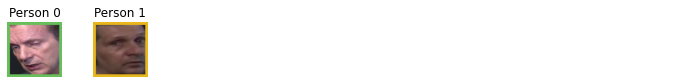

<Figure size 1080x972 with 0 Axes>

In [47]:
row_number = int(np.ceil(cluster_by_frames.shape[0]/10))

show_people_video()

plt.figure(figsize = (15,row_number*1.5))
gs1 = gridspec.GridSpec(row_number, 10)
gs1.update(wspace=0, hspace=0) # set the spacing between axes. 
i = 0
for frame in tqdm(cluster_by_frames.index.values):
    thumb = draw_lines(frame, cluster_by_frames.loc[frame][0], cluster_by_frames.loc[frame][1], lines=False)
    tag_path
    
    cv2.imwrite(f'{tag_path}/frame_{frame}.jpg',thumb[:,:,::-1])
    #ax1 = plt.subplot(gs1[i])  
    #plt.subplots_adjust(hspace=0, wspace=0)
    #ax1.imshow(thumb)
    #ax1.axis('off')
    #ax1.set_aspect('equal')
    
    i = i + 1

## Cluster Matching

In [48]:
classes_col = f'cluster_{alg}'

cluster_embeddings = pd.DataFrame(clusters['embeddings'].values.tolist(),index=clusters.index)
cluster_embeddings[classes_col] = clusters[classes_col]
centroids = cluster_embeddings.groupby([classes_col]).mean()

centroids

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
cluster_agglomerative,,,,,,,,,,,,,,,,,,,,,
0,8.458855,1.020465,0.066367,0.031085,0.049347,0.668078,7.530588,0.010912,0.238646,0.009971,...,1.784082,0.055116,2.159545,0.364120,3.552542,2.208135,0.006788,2.965242,3.532124,5.174860
1,0.039382,0.006489,0.671247,1.094962,0.586401,0.486517,0.230514,0.762318,0.386214,0.895420,...,0.058938,0.037195,6.512974,0.006241,0.069794,3.348341,0.018757,0.310255,12.249279,0.033762


In [49]:
from faces_clustering import FaceSearcher

df_embs = pd.read_pickle('../../data/clusters_train_leg55.pkl').loc['senet50']
df_embs.urls = df_embs.urls.apply(lambda x: x
                                  .replace('C:/Users/paulo/Documents/FacesProject', '/home/paulo/Documentos')
                                  .replace('\\','/'))
df_embs.head()


searcher = FaceSearcher(face_embs = df_embs, classes_col = classes_col)

In [50]:
_, results = searcher.closest_centroids(embs_query = centroids.values)

In [51]:
softmax = lambda x: np.exp(x)/sum(np.exp(x))
def m1(x, k):
    m1 = softmax((1/x).nlargest(k)).head(1)
    return (m1.index.values[0],m1.values[0])

In [52]:
assign_cluster = lambda x: m1(x,k=5)[0] if m1(x,k=5)[1] >= 0.5 else -1

Person 0 is:


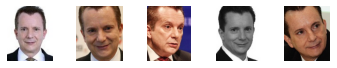

Person 1 is:
Nobody


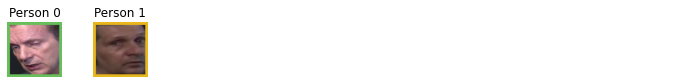

In [53]:
max_samples = 5

for i, result in enumerate(results):    
    assigned_cluster = assign_cluster(result)
    print(f"Person {i} is:")
    if assigned_cluster != -1:
        fig, axes = plt.subplots(nrows=1, ncols=max_samples, figsize=(6, 1))
        urls = df_embs.loc[df_embs.cluster_agglomerative == assigned_cluster].head(max_samples).urls
        #urls = df_embs.loc[df_embs.cluster_agglomerative == 324].head(max_samples).urls
        [axi.set_axis_off() for axi in axes.ravel()]
        for j, url in enumerate(urls):
            axes[j].imshow(cv2.imread(url)[:,:,::-1])
            #axes[i].axis('off')
        #plt.title = f"Person {i}"
        
        plt.show()
    else:
        print("Nobody")
show_people_video()

In [54]:
def m1_todos(x, k):
    m1 = softmax((1/x).nlargest(k))
    return m1
m1_todos(results[0],5)

cluster_agglomerative
216    0.998138
498    0.001326
141    0.000190
344    0.000176
22     0.000171
dtype: float64